In [1]:
import re
import csv
import random
import requests
import datetime
from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# Crawling data using BeautifulSoup package

In [2]:
session = requests.Session()
header = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'}

In [3]:
def get_proxies():
    url = 'https://free-proxy-list.net/'
    r = requests.get(url)
    while not r.status_code == 200:
        r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    trs = soup.find('table', class_ = 'table table-striped table-bordered').find('tbody').find_all('tr')
    proxy = []
    for tr in trs:
        tds = tr.find_all('td')
        if tds[6].text == 'no':
            proxy.append('http://'+tds[0].text + ':' + tds[1].text)
    return proxy

In [4]:
def read_url(url, proxy):    
    id = random.randint(0, 50)
    session.proxies = {'http': proxy[id]}
    r = session.get(url, headers = header)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

In [5]:
def month_converter(month):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return months.index(month) + 1

In [6]:
with open('data.csv', "w", newline='') as fp:
    wr = csv.writer(fp, dialect='excel')
    wr.writerow(['Number', 'Platform', 'Date', 'Passed Day', 'Meta Score', 'User Score'])

    for n in range(200):
      url = 'https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page={}'.format(n)
      if n%20 == 0:
        proxy = get_proxies()
      soup = read_url(url, proxy)
      r = requests.get(url, headers=header)
      while not r.status_code == 200:
          r = requests.get(url, headers=header)
      soup = BeautifulSoup(r.text, 'html.parser')

      records = soup.find_all('td', class_ = 'clamp-summary-wrap')
      for record in records:
        number = int(re.findall(r'\d+', record.find('span', class_='title numbered').text)[0])
        details_soup = record.find('div', class_='clamp-details').find_all('span')
        platform = details_soup[1].text.strip()

        rec_date = details_soup[2].text.strip().replace(',', '').split(' ')
        year = int(rec_date[2])
        month = month_converter(rec_date[0][:3])
        day = int(rec_date[1])
        rec_date = datetime.date(year, month, day)

        delta = datetime.date.today() - rec_date
        pass_days = delta.days

        meta_score_classes = ['metascore_w large game positive', 
                              'metascore_w large game mixed', 
                              'metascore_w large game negative']
        for meta_score_class in meta_score_classes:
          try:
            meta_score = float(record.find('div', class_=meta_score_class).text.strip())
            break
          except:
            pass

        user_score_classes = ['metascore_w user large game positive', 
                              'metascore_w user large game mixed', 
                              'metascore_w user large game negative']
        for user_score_class in user_score_classes:
          try:
            user_score = float(record.find('div', class_=user_score_class).text.strip())
            break
          except:
            pass

        wr.writerow([number, platform, rec_date, pass_days, meta_score, user_score])

# Pre - processing

*Remove rows with missing values*

In [7]:
df = pd.read_csv('data.csv')
df = df[df != '']
df = df.dropna()
df = df.reset_index(drop = True)
df.head(10)
df.head()

,Number,Platform,Date,Passed Day,Meta Score,User Score
0,1,Nintendo 64,1998-11-23,8801,99.0,9.1
1,2,PlayStation,2000-09-20,8134,98.0,7.4
2,3,PlayStation 3,2008-04-29,5356,98.0,7.8
3,4,Dreamcast,1999-09-08,8512,98.0,8.4
4,5,Xbox 360,2008-04-29,5356,98.0,8.0


*remove column 'Number'*

In [8]:
df.drop(['Number'], axis=1, inplace = True)
df.head()

,Platform,Date,Passed Day,Meta Score,User Score
0,Nintendo 64,1998-11-23,8801,99.0,9.1
1,PlayStation,2000-09-20,8134,98.0,7.4
2,PlayStation 3,2008-04-29,5356,98.0,7.8
3,Dreamcast,1999-09-08,8512,98.0,8.4
4,Xbox 360,2008-04-29,5356,98.0,8.0


# EDA

In [9]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

*Number of years and platforms*

In [10]:
print('Number of Years:', len(df['Year'].unique()))
print('Number of Platforms:', len(df['Platform'].unique()))

Number of Years: 28
Number of Platforms: 22


*Statistical Features*

In [11]:
df.describe()

,Passed Day,Meta Score,User Score,Year
count,19945.000000,19945.000000,19945.000000,19945.000000
mean,3905.728754,70.738330,6.935252,2011.754124
std,2353.674220,12.168866,1.360307,6.472117
min,13.000000,11.000000,0.300000,1995.000000
25%,1798.000000,64.000000,6.300000,2006.000000
50%,3858.000000,72.000000,7.200000,2012.000000
75%,5888.000000,80.000000,7.900000,2018.000000
max,10104.000000,99.000000,9.700000,2022.000000


## Top Average Meta Scores by Year

<AxesSubplot:xlabel='Year'>

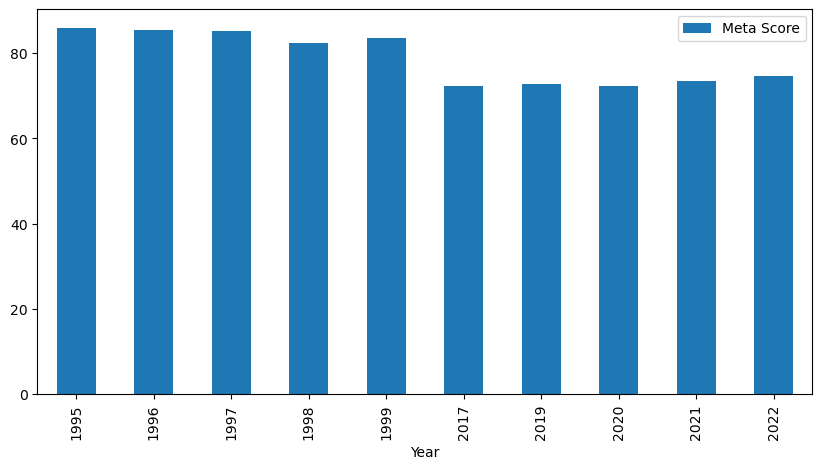

In [12]:
dfx_year = df.groupby('Year').mean()
df10 = dfx_year.nlargest(10, 'Meta Score')
df10[['Meta Score']].groupby(['Year']).mean().plot.bar(figsize=(10, 5))

## Top Average User Scores by Year

<AxesSubplot:xlabel='Year'>

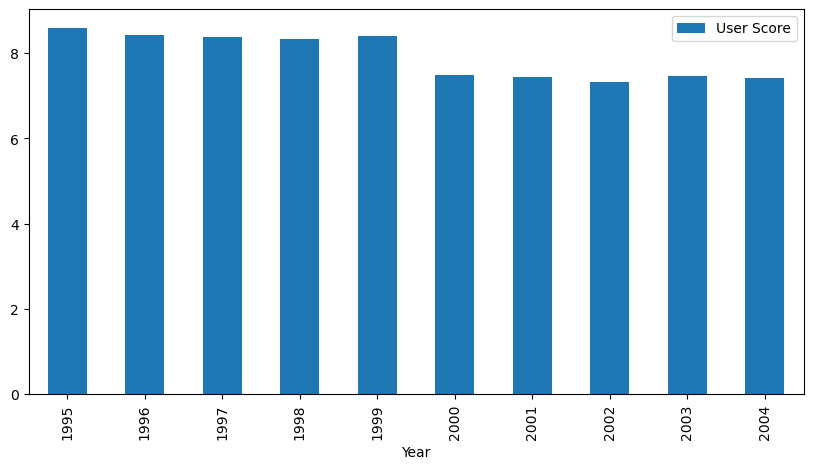

In [13]:
df10 = dfx_year.nlargest(10, 'User Score')
df10[['User Score']].groupby(['Year']).mean().plot.bar(figsize=(10, 5))

## Scatter plot between average meta score and user score by the year

<AxesSubplot:xlabel='Meta Score', ylabel='User Score'>

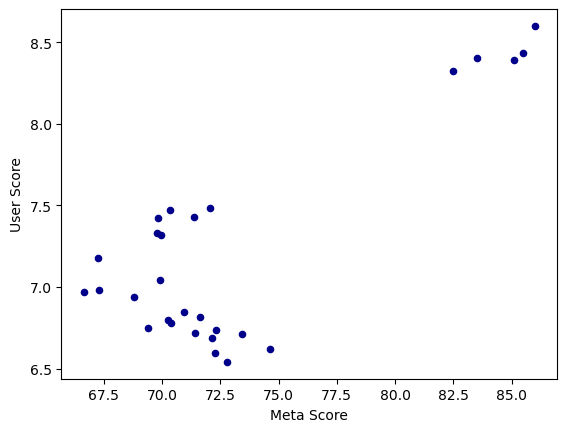

In [14]:
dfx_year.plot.scatter(x='Meta Score', y='User Score', c='DarkBlue')

## Top Average Meta Scores by Platform

<AxesSubplot:xlabel='Platform'>

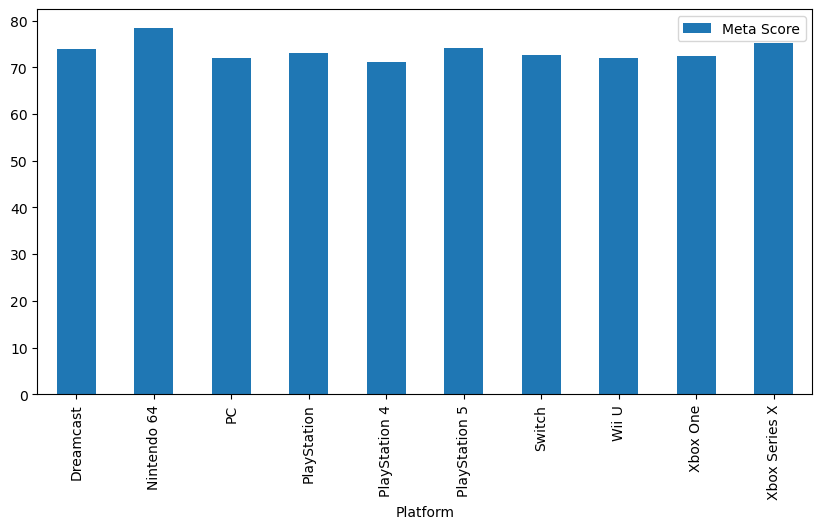

In [15]:
dfx_platform = df.groupby('Platform').mean()
df10 = dfx_platform.nlargest(10, 'Meta Score')
df10[['Meta Score']].groupby(['Platform']).mean().plot.bar(figsize=(10, 5))

## Top Average User Scores by Platform

<AxesSubplot:xlabel='Platform'>

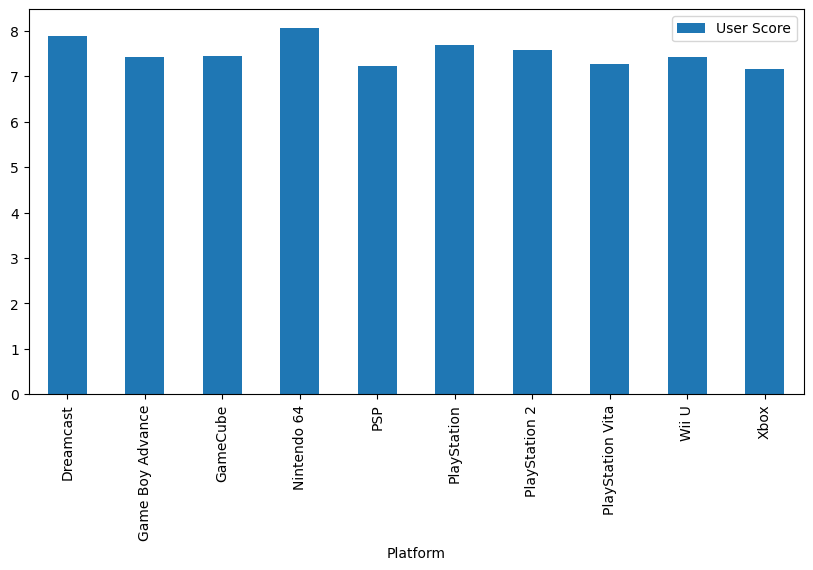

In [16]:
df10 = dfx_platform.nlargest(10, 'User Score')
df10[['User Score']].groupby(['Platform']).mean().plot.bar(figsize=(10, 5))

## Scatter plot between average meta score and user score by the platform

<AxesSubplot:xlabel='Meta Score', ylabel='User Score'>

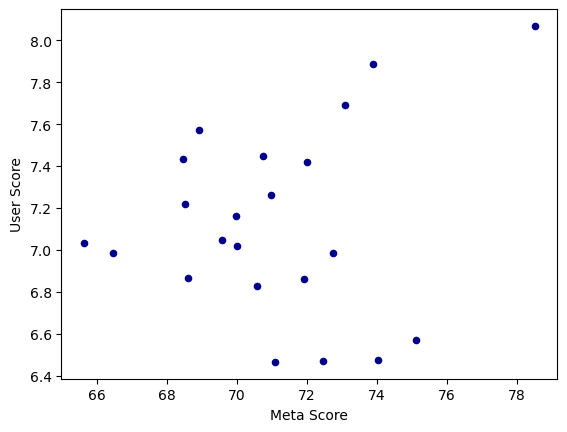

In [17]:
dfx_platform.plot.scatter(x='Meta Score', y='User Score', c='DarkBlue')

*Remove string columns*

In [18]:
df_numerical = df.drop(['Platform', 'Date'], axis = 1)
df_numerical = df_numerical[['Passed Day', 'Year', 'Meta Score', 'User Score']]
df_numerical.head()

,Passed Day,Year,Meta Score,User Score
0,8801,1998,99.0,9.1
1,8134,2000,98.0,7.4
2,5356,2008,98.0,7.8
3,8512,1999,98.0,8.4
4,5356,2008,98.0,8.0


# Regression Models
## Correlation Analysis

In [19]:
corr = df_numerical.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Passed Day,Year,Meta Score,User Score
Passed Day,1.00,-1.00,-0.10,0.21
Year,-1.00,1.00,0.09,-0.21
Meta Score,-0.10,0.09,1.00,0.51
User Score,0.21,-0.21,0.51,1.00


In [20]:
X = df_numerical[['Passed Day', 'Year', 'Meta Score']]
y = df_numerical['User Score']

# Train Regression models
RF = RandomForestRegressor()
LR = LinearRegression()
RF.fit(X, y)
LR.fit(X, y)

LinearRegression()

In [21]:
# Predict gross using trained regression models
RF_pred = RF.predict(X)
LR_pred = LR.predict(X)

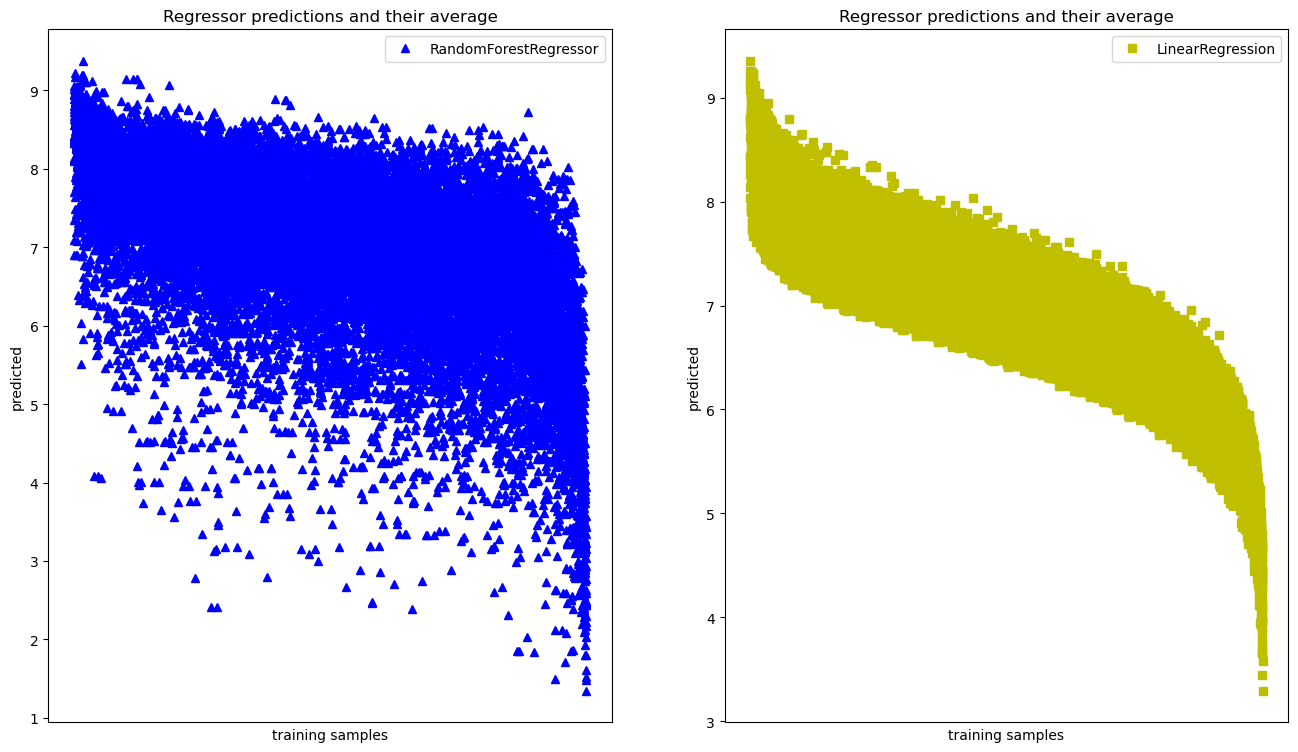

In [22]:
fig, axs = plt.subplots(1,2,figsize=(16,9))

axs[0].plot(RF_pred, "b^", label="RandomForestRegressor")
axs[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
axs[0].set_ylabel("predicted")
axs[0].set_xlabel("training samples")
axs[0].legend(loc="best")
axs[0].set_title("Regressor predictions and their average")

axs[1].plot(LR_pred, "ys", label="LinearRegression")
axs[1].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
axs[1].set_ylabel("predicted")
axs[1].set_xlabel("training samples")
axs[1].legend(loc="best")
axs[1].set_title("Regressor predictions and their average")

plt.show()

## Calculate RMSE values

In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = []
pred_PTS = pd.DataFrame({'User Score': y, 'RF_User_Score':RF_pred, 'LR_User_Score': LR_pred})
rmse.append(mean_squared_error(pred_PTS['User Score'], pred_PTS['RF_User_Score'], squared=False))
rmse.append(mean_squared_error(pred_PTS['User Score'], pred_PTS['LR_User_Score'], squared=False))
methods = ['RandomForestRegressor', 'LinearRegression']
RMSE = pd.DataFrame({'Method': methods,'RMSE': rmse})
RMSE

,Method,RMSE
0,RandomForestRegressor,0.528234
1,LinearRegression,1.113645


<AxesSubplot:xlabel='Method'>

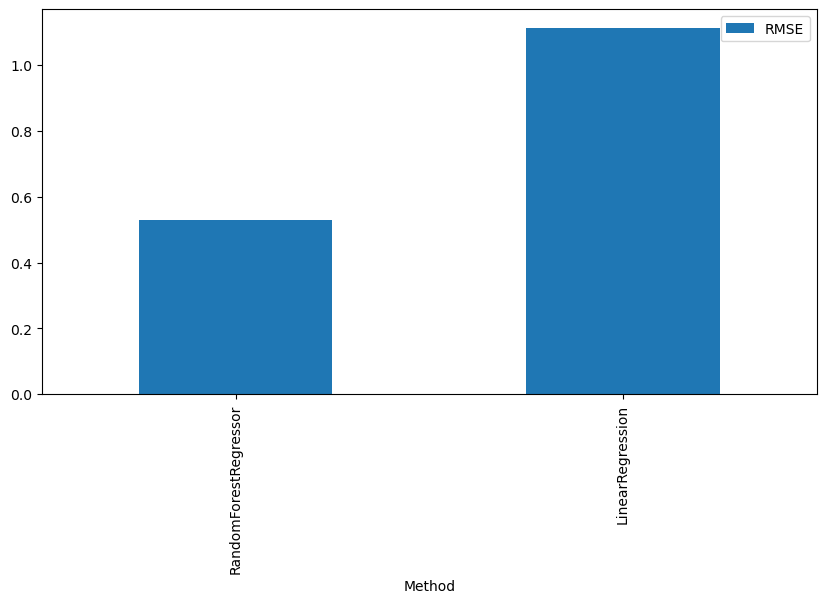

In [24]:
RMSE.plot.bar(x = 'Method', y = 'RMSE', figsize=(10, 5))

*From above table and graph, we can see that Random Forest Regressor is the best. The RMSE of Random Forest Regressor is less than 1.
Now lets predict User Score for all values.*

# Predict the User Score using other features

In [25]:
RF_pred = RF.predict(X)
df_numerical['pred_User_Score'] = RF_pred
df_numerical.head(10)

,Passed Day,Year,Meta Score,User Score,pred_User_Score
0,8801,1998,99.0,9.1,9.012000
1,8134,2000,98.0,7.4,7.345000
2,5356,2008,98.0,7.8,8.109267
3,8512,1999,98.0,8.4,8.553000
4,5356,2008,98.0,8.0,8.109267
5,5525,2007,97.0,9.1,8.958500
6,4602,2010,97.0,9.1,8.893983
7,1524,2018,97.0,8.2,8.419233
8,2962,2014,97.0,7.9,8.120333
9,3389,2013,97.0,8.3,8.328000
